In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.patches as patches
import os
from PIL import Image
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# all the path in the scc
# /project/ece601/input_pneumonia
dataset_path = '/project/ece601/input_pneumonia'
working_path = '/project/ece601/working'
print(os.listdir(dataset_path))

['stage_2_sample_submission.csv', 'stage_2_test_images', 'stage_2_train_images', 'GCP%20Credits%20Request%20Link%20-%20RSNA.txt', 'stage_2_train_labels.csv', 'stage_2_detailed_class_info.csv']


In [4]:
! which python

/usr3/graduate/minzhou/ec601-project/env/bin/python


In [5]:
import pydicom # Read, modify and write DICOM files with python code
import matplotlib.pyplot as plt

In [6]:
random_stat = 123
np.random.seed(random_stat)

# Load the dataset

In [7]:
!ls /project/ece601/input_pneumonia && pwd

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_2_test_images
stage_2_detailed_class_info.csv		       stage_2_train_images
stage_2_sample_submission.csv		       stage_2_train_labels.csv
/usr3/graduate/minzhou/ec601-project/working


## Labels

In [8]:
df = pd.read_csv(f'{dataset_path}/stage_2_train_labels.csv', engine='python')
print(df.head(5))
print(f'The total number of trianing examples: {len(df)}')

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
The total number of trianing examples: 30227


1. Positive example: target == 0 (No pneumonia)

In [9]:
print(df.iloc[0])

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
Name: 0, dtype: object


1. Negative example: target == 1 (has pneumonia)
 * Note: a positive example may have mulitple bboxes

In [10]:
print(df.iloc[4])

patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object


## Input data and dimension

In [11]:
patientId = df['patientId'][0]
dcm_file = f'{dataset_path}/stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)

print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

<class 'numpy.ndarray'>
uint8
(1024, 1024)


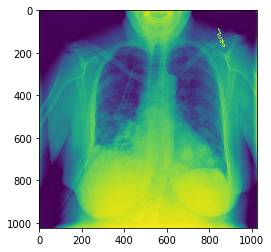

In [12]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)
plt.imshow(im)
plt.show()

### Darknet

In [3]:
!git clone https://github.com/pjreddie/darknet

# Build gpu version darknet
# !cd darknet && sed '1 s/^.*$/GPU=1/; 2 s/^.*$/CUDNN=1/' -i Makefile

Initialized empty Git repository in /usr3/graduate/minzhou/ec601-project/working/darknet/.git/
remote: Enumerating objects: 5901, done.
remote: Total 5901 (delta 0), reused 0 (delta 0), pack-reused 5901
Receiving objects: 100% (5901/5901), 6.14 MiB, done.
Resolving deltas: 100% (3944/3944), done.


In [25]:
# change Makefile OPTS=-O3
# comment include/darknet.h typedef struct network network;

In [3]:
!cd darknet && make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/image.c -o obj/image.o
In file included from ./s

gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/local_layer.c -o obj/local_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/shortcut_layer.c -o obj/shortcut_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/logistic_layer.c -o obj/logistic_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/activation_layer.c -o obj/activation_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/rnn_layer.c -o obj/rnn_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/gru_layer.c -o obj/gru_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -O3 -c ./src/crnn_layer.c -o obj/crnn_layer.o
gcc -Iinclude/ -Isrc/ -Wall -

In [3]:
!cp darknet/darknet darknet_gpu

## Training YOLO on RSNA 

### Generate Labels for YOLO3

In [13]:
DATA_DIR = dataset_path

train_dcm_dir = os.path.join(DATA_DIR, "stage_2_train_images")
test_dcm_dir = os.path.join(DATA_DIR, "stage_2_test_images")

img_dir = os.path.join(working_path, "images")  # .jpg
label_dir = os.path.join(working_path, "labels")  # .txt
metadata_dir = os.path.join(working_path, "metadata") # .txt

# YOLOv3 config file directory
cfg_dir = os.path.join(working_path, "cfg")
# YOLOv3 training checkpoints will be saved here
backup_dir = os.path.join(working_path, "backup")

for directory in [img_dir, label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

In [14]:
!ls -shtl

total 156M
352K -rwxrwxrwx  1 minzhou ece601 327K Nov  8 21:14 yolo_model-Copy1.ipynb
 32K drwxr-xr-x 13 minzhou ece601  32K Nov  8 05:48 darknet
 64K -rw-r--r--  1 minzhou ece601  64K Nov  8 05:19 bad.list
 96K -rw-r--r--  1 minzhou ece601  96K Nov  8 05:09 predictions.jpg
   0 drwxr-xr-x  2 minzhou ece601  512 Nov  8 05:04 cfg
 96K -rw-r--r--  1 minzhou ece601  96K Nov  8 03:58 test.jpg
 32K drwxr-xr-x  2 minzhou ece601  32K Nov  8 01:40 backup
128K -rwxrwxrwx  1 minzhou ece601 110K Nov  5 17:43 data-analysis-of-rsna-library.ipynb
155M -rw-r--r--  1 minzhou ece601 155M Mar 25  2018 darknet53.conv.74


## Generate  .txt file for YOLO3

In [15]:
annots = pd.read_csv(os.path.join(DATA_DIR, "stage_2_train_labels.csv"))
annots.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [16]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)
    
def save_label_from_dcm(label_dir, patient_id, row=None):
    # rsna defualt image size
    img_size = 1024
    label_fp = os.path.join(label_dir, "{}.txt".format(patient_id))
    
    f = open(label_fp, "a")
    if row is None:
        f.close()
        return

    top_left_x = row[1]
    top_left_y = row[2]
    w = row[3]
    h = row[4]
    
    # 'r' means relative. 'c' means center.
    rx = top_left_x/img_size
    ry = top_left_y/img_size
    rw = w/img_size
    rh = h/img_size
    rcx = rx+rw/2
    rcy = ry+rh/2
    
    line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
    
    f.write(line)
    f.close()
    
def save_yolov3_data_from_rsna(dcm_dir, img_dir, label_dir, annots):
    for row in tqdm(annots.values):
        patient_id = row[0]

        img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
        if os.path.exists(img_fp):
            save_label_from_dcm(label_dir, patient_id, row)
            continue
        
        target = row[5]
        save_label_from_dcm(label_dir, patient_id, row)
        save_img_from_dcm(dcm_dir, img_dir, patient_id)

In [16]:
save_yolov3_data_from_rsna(train_dcm_dir, img_dir, label_dir, annots)

100%|██████████| 30227/30227 [23:14<00:00, 21.68it/s] 


In [18]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [19]:
patient_id_series = annots[annots.Target == 1].patientId.drop_duplicates()

tr_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))

# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)

The # of train set: 5410, The # of validation set: 602


In [25]:
from shutil import copyfile

0 nan nan nan nan



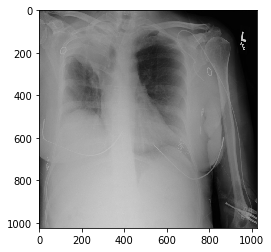

0 nan nan nan nan



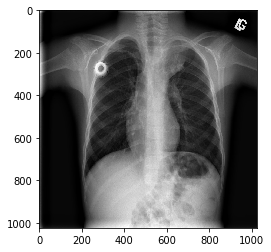

0 nan nan nan nan



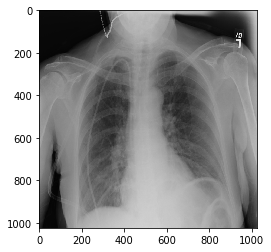

In [38]:
for i in np.random.randint(0, 1000, 3):
    ex_patient_id = annots[annots.Target == 0].patientId.values[i]
    ex_img_path = os.path.join(img_dir, "{}.jpg".format(ex_patient_id))
    ex_label_path = os.path.join(label_dir, "{}.txt".format(ex_patient_id))
    
    plt.imshow(cv2.imread(ex_img_path))

    img_size = 1014
    with open(ex_label_path, "r") as f:
        for line in f:
            print(line)
            class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
            x = (rcx-rw/2)*img_size
            y = (rcy-rh/2)*img_size
            w = rw*img_size
            h = rh*img_size
            plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])
    copyfile(ex_img_path, f'neg_test{i}.jpg')
    plt.savefig(f'neg_test{i}_label.jpg')
    plt.show()


In [28]:
def save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_id in series:
            save_img_from_dcm(test_dcm_dir, img_dir, patient_id)
            line = "{}\n".format(os.path.join(img_dir, "{}.jpg".format(patient_id)))
            f.write(line)

In [29]:
test_dcm_fps = list(set(glob.glob(os.path.join(test_dcm_dir, '*.dcm'))))
test_dcm_fps = pd.Series(test_dcm_fps).apply(lambda dcm_fp: dcm_fp.strip().split("/")[-1].replace(".dcm",""))

save_yolov3_test_data(test_dcm_dir, img_dir, metadata_dir, "te_list.txt", test_dcm_fps)


## Modify Cfg for RSNA data

In [45]:
data_extention_file_path = os.path.join(cfg_dir, 'rsna.data')
with open(data_extention_file_path, 'w') as f:
    contents = """classes= 1
train  = {}
valid  = {}
names  = {}
backup = {}
    """.format(os.path.join(metadata_dir, "tr_list.txt"),
               os.path.join(metadata_dir, "val_list.txt"),
               os.path.join(cfg_dir, 'rsna.names'),
               backup_dir)
    f.write(contents)

In [47]:
!cat /project/ece601/working/cfg/rsna.data

classes= 1
train  = /project/ece601/working/metadata/tr_list.txt
valid  = /project/ece601/working/metadata/val_list.txt
names  = /project/ece601/working/cfg/rsna.names
backup = /project/ece601/working/backup
    

In [41]:
!echo "pneumonia" > /project/ece601/working/cfg/rsna.names

## Download Pretrained Convolutional Weights

In [30]:
!wget -q https://pjreddie.com/media/files/darknet53.conv.74

## Pre-generated .cfg_train

In [1]:
!wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=13huTgMdLhwc3XGF3ucbPXR3MFRk0zgaN" -O cfg/rsna_yolov3.cfg_train

## Training

* Note: the training process is done on the bu scc1 with gpu and darknet module.

In [ ]:
!darknet detector train cfg/rsna.data cfg/rsna_yolov3.cfg_train darknet53.conv.74 -i 0 | tee train_log.txt

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

Done!
Learning Rate: 0.001, Momentum: 0.9, Decay: 0.0005
Resizing
576
Loaded: 0.364253 seconds
Region 82 Avg IOU: 0.421275, Class: 0.565166, Obj: 0.444795, No Obj: 0.476953, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495244, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413980, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.477411, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.353655, Class: 0.405939, Obj: 0.193469, No Obj: 0.494271, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.412986, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.151483, Class: 0.466193, Obj: 0.699847, No Obj: 0.477394, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496469, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj:

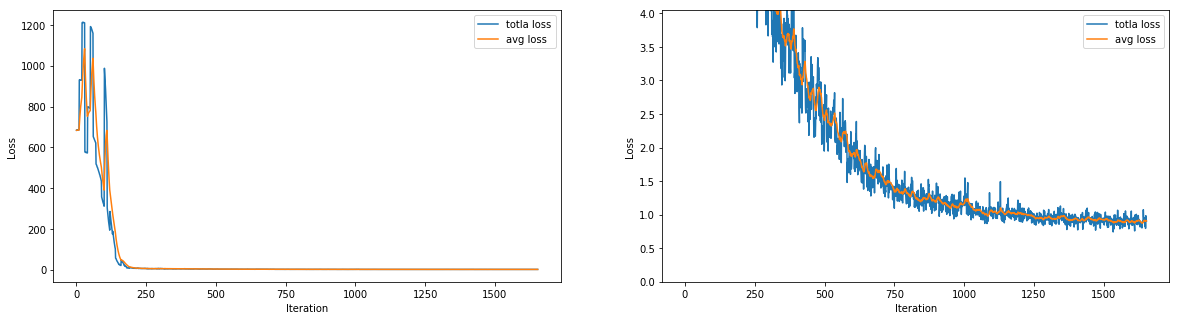

In [42]:
iters = []
losses = []
total_losses = []
with open("train_log.txt", 'r') as f:
    for i,line in enumerate(f):
        if "images" in line:
            iters.append(int(line.strip().split()[0].split(":")[0]))
            losses.append(float(line.strip().split()[2]))        
            total_losses.append(float(line.strip().split()[1].split(',')[0]))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
sns.lineplot(iters, total_losses, label="totla loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.savefig('Loss1.jpg')

plt.subplot(1,2,2)
sns.lineplot(iters, total_losses, label="totla loss")
sns.lineplot(iters, losses, label="avg loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim([0, 4.05])
plt.savefig('Loss2.jpg')

## Show some test results

In [12]:
test_images_path = os.path.join(os.getcwd(), 'demo_images')
for dirpath,_,filenames in os.walk(test_images_path):
    for f in filenames:
        print(os.path.abspath(os.path.join(dirpath, f)))

/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/neg_test253_label.jpg
/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/pos_test339.jpg
/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/pos_test846.jpg
/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/prediction.png
/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/pos_test846_label.jpg
/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/pos_test339_label.jpg
/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/pos_test409_label.jpg
/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/neg_test608.jpg
/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/Loss1.jpg
/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/Loss2.jpg
/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/neg_test420.jpg
/Users/minzhou/Desktop/EC601/ec601-project/yolo_model/demo_images/neg_test608_label.jpg

In [13]:
# !wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=10Yk6ZMAKGz5LeBbikciALy82aK3lX-57" -O cfg/rsna_yolov3.cfg_test

In [15]:
!cd darknet && ./darknet detector test ../cfg/rsna.data ../cfg/rsna_yolov3.cfg_test ../backup/rsna_yolov3_900.weights ../demo_images/pos_test339.jpg -thresh 0.05

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

Loading weights from ../backup/rsna_yolov3_900.weights...Done!
../demo_images/pos_test339.jpg: Predicted in 22.757284 seconds.
pneumonia: 33%
pneumonia: 9%
pneumonia: 6%
pneumonia: 5%


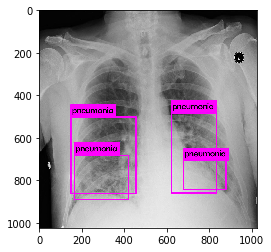

In [16]:
plt.imshow(cv2.imread("darknet/predictions.jpg"))

### True label

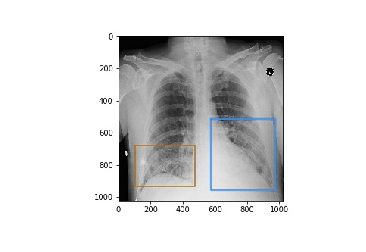

In [21]:
plt.imshow(cv2.imread('demo_images/pos_test339_label.jpg'))
plt.axis('off')
plt.show()